In [161]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, mean_squared_error
INF = np.inf

### Step 0: Helper functions for wl_edge_kernel()

In [162]:
def original_count(nl, Map, ctr): 
    num_labels = nl.shape[0]
    labels = np.zeros(num_labels) 
    
    for i in range(num_labels): 
        str_label = str(nl[i]) 
        if(str_label in Map): 
            labels[i] = Map[str_label] 
        else: 
            Map[str_label] = ctr
            labels[i] = ctr
            ctr += 1 
        
    labels = np.int64(labels)
    return {'labels': labels, 'Map': Map, 'ctr': ctr}



def get_edge_map(nl, am): 

    """
    get_edge_map(l1, am1)
    #return: 
    {'3-3': 24, '3-6': 1, '6-7': 2}
    """
    
    n = nl.shape[0]
    square = np.matlib.repmat(np.asmatrix(nl).T, 1, n)
    Start = np.minimum(square, square.T)
    End = np.maximum(square, square.T)
    Edges = np.triu(am, 1)
    index = np.where(Edges == 1)
    row = index[0]; 
    col = index[1];
    
    edge_map = dict() 
    n_pairs = len(row)
    for k in range(n_pairs): 
        i = row[k] 
        j = col[k]
        start_ep = Start[i, j]
        end_ep = End[i, j]

        edge = str(start_ep) + "-" + str(end_ep) #key: ordered pair name
        if (edge in edge_map): 
            edge_map[edge] += 1; 
        else: 
            edge_map[edge] = 1; 
            
    return edge_map



def compress_label(nl, am):  
    Map = dict(); ctr = 0
    phi1 = []
    phi2 = [] 
    new_labels = np.zeros(nl.shape[0])
    
    for i in range(nl.shape[0]): 
        neighbors_labels = nl[np.where(am[i] == 1)]
        str_label = str(nl[i])
        
        for neighbor in range(neighbors_labels.shape[0]): 
            str_label += str(neighbor)
        
        if(str_label in Map): 
            new_labels[i] = Map[str_label]
        else: 
            Map[str_label] = ctr
            new_labels[i] = ctr
            ctr += 1 
            
    return {'new_labels': new_labels, 'Map': Map, 'ctr': ctr}        

### Step 1: wl_edge_kernel function

In [163]:
"""
edge kernel of two gra_phs  
"""
def wl_edge_kernel (graph1, graph2, H):  
    K = 0 
    
    #read graph structure 
    am1, l1 = graph1[0], graph1[1]
    am2, l2 = graph2[0], graph2[1]
    l1 = l1.tolist()[0]
    l2 = l2.tolist()[0]
    
    #number of distinct nodes 
    #size1 = len(set(l1))
    #size2 = len(set(l2))
    
    
    ###Step 1: Initialization/original count
    Map = dict();
    ctr = 0 
    
    #for graph 1 
    res1 = original_count(l1, Map, ctr)
    Map = res1['Map']
    ctr = res1['ctr']
    
    #for graph 2
    res2 = original_count(l2, Map, ctr)
    Map = res2['Map']
    ctr = res2['ctr']
    
    #get initial labels  
    labels1 = res1['labels']
    labels2 = res2['labels']
    
    ###Step 2: Find ordered endpoints labels and # of occurences
    edge_map1 = get_edge_map(labels1, am1)
    edge_map2 = get_edge_map(labels2, am2)
    
    ###Step 3: Compute inner product of edge_map1 & edge_map2 
    edges1 = set(edge_map1.keys())
    edges2 = set(edge_map2.keys())
    all_edges = edges1 | edges2 
    phi1 = []
    phi2 = []
    for edge in all_edges: 
        phi1.append(edge_map1[edge] if edge in edges1 else 0)
        phi2.append(edge_map2[edge] if edge in edges2 else 0)
    
    dot = np.dot(np.asmatrix(phi1), np.asmatrix(phi2).T)
    K += dot
        
    
    #Step 4: Repeat the above process for H iterations. 
    
    for h in range(H):

        ###Step 4.a: get compressed labels 
        #for graph 1 
        res1 = compress_label(labels1, am1)
        Map = res1['Map']
        ctr = res1['ctr']

        #for graph 2
        res2 = compress_label(labels2, am2)
        Map = res2['Map']
        ctr = res2['ctr']

        #update labels for h-th iteration
        labels1 = res1['new_labels']
        labels2 = res2['new_labels']

        ###Step 4.b: Find ordered endpoints labels of edges in two graphs
        edge_map1 = get_edge_map(labels1, am1)
        edge_map2 = get_edge_map(labels2, am2)

        ###Step 4.c: compute inner product of edge_map1 & edge_map2 
        edges1 = set(edge_map1.keys())
        edges2 = set(edge_map2.keys())
        all_edges = edges1 | edges2 
        phi1 = []
        phi2 = []
        
        for edge in all_edges: 
            phi1.append(edge_map1[edge] if edge in edges1 else 0)
            phi2.append(edge_map2[edge] if edge in edges2 else 0)

        dot = np.dot(np.asmatrix(phi1), np.asmatrix(phi2).T)
       
        K += dot
    
    #print("H: ", H, " dot: ", K)
        
    return K

### Step 2: Read data

In [164]:
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
print("X shape: ", mutag.shape)
print("Y shape: ", lmutag.shape)
N = y.shape[0]

X shape:  (188,)
Y shape:  (188,)


### Step 3: Compute the kernel matrix K 

In [165]:
#try two object  first  
m1 = mutag[0, ]
m2 = mutag[1, ]
print("Try two object  first; K(x1, x2) = : ", wl_edge_kernel(m1, m2, 10))

K = np.zeros([N, N])
for i in range(N): 
    if( i % 20 == 0): 
        print(i)
    for j in range(N):
        if (i <= j ):
            graph1 = X[i, ]
            graph2 = X[j, ]
            K[i, j] = wl_edge_kernel(graph1, graph2, 3)
        else: 
            K[i, j] = K[j, i]

Now we have the Kernel matrix K (188x188)

### Step 4: Permute, split and evaluate performances of Kernel-based SVM

In [199]:
"""
Compute accuracy of SVM 

Parameters:  
------------
K: precomputed Kernel matrix 
N: data set size 
c: penalty for SVC
"""
def get_accuracy (K, N, c): 

    #Paper: To exclude random effects of fold assignments, 
    #each repeat experiment 10 times  

    #Record the performance for each parameter trial on test set
    perf_all_val = []

    for t in range(10):  

        random_state = int(t)
        np.random.seed(random_state)
        idx_perm = np.random.permutation(N)

        #Permute the data 
        y_perm = y[idx_perm]
        K_perm = K[:, idx_perm]
        K_perm = K_perm[idx_perm, :]

        #The paper use 10-folder CV (training: 90%; test: 10%)
        num_train = int (N * (9/10))
        num_test = N - num_train 

        #Split the kernel matrix 
        K_train = K_perm[0:num_train, 0:num_train] 
        K_test = K_perm[num_train:N, 0:num_train]
        y_train = y_perm[0:num_train]
        y_test = y_perm[num_train:N]

        #print("K_train shape: ", K_train.shape, "  y_train shape: ", y_train.shape)
        #print("K_test shape:  ", K_test.shape,  "  y_test shape: ", y_test.shape)


        #Fit classifier on training data 
        clf = svm.SVC(kernel = 'precomputed', C = c)
        clf.fit(K_train, y_train)

        #predict on test  
        y_pred_test = clf.predict(K_test)
        #print("y_pred_test: ", y_pred_test)

        #accuracy on test set  
        acc = accuracy_score(y_test, y_pred_test);
        perf_all_val.append(acc) 

        #print("The performance on the test set is: %3f" % acc)

    print("\n average performan: ", np.mean(perf_all_val))
    return np.mean(perf_all_val)

In [201]:
c_grid = np.array([0.01, 0.1, 1, 10, 100, 1000])
h_grid = [x + 1 for x in list(range(10))]

perf = []
h_para = [] 
c_para = [] 
for h in h_grid: 
    for c in c_grid:  
        
        h_para.append(h)
        c_para.append(c)
        print("h: ", h, " c: ", c)
        
        #compute Kernel matrix K, given H  
        K = np.zeros([N, N])
        for i in range(N): 
            for j in range(N):
                if (i <= j ):
                    graph1 = X[i, ]
                    graph2 = X[j, ]
                    K[i, j] = wl_edge_kernel(graph1, graph2, h)
                else: 
                    K[i, j] = K[j, i]
        
        acc = get_accuracy(K, N, c)
        perf.append(acc)
        h_para.append(h)
        c_para.append(c)

h:  1  c:  0.01

 average performan:  0.821052631579
h:  1  c:  0.1

 average performan:  0.863157894737
h:  1  c:  1.0

 average performan:  0.831578947368
h:  1  c:  10.0

 average performan:  0.805263157895
h:  1  c:  100.0

 average performan:  0.826315789474
h:  1  c:  1000.0

 average performan:  0.826315789474
h:  2  c:  0.01

 average performan:  0.826315789474
h:  2  c:  0.1

 average performan:  0.857894736842
h:  2  c:  1.0

 average performan:  0.831578947368
h:  2  c:  10.0

 average performan:  0.805263157895
h:  2  c:  100.0

 average performan:  0.826315789474
h:  2  c:  1000.0

 average performan:  0.826315789474
h:  3  c:  0.01

 average performan:  0.826315789474
h:  3  c:  0.1

 average performan:  0.852631578947
h:  3  c:  1.0

 average performan:  0.836842105263
h:  3  c:  10.0

 average performan:  0.810526315789
h:  3  c:  100.0

 average performan:  0.826315789474
h:  3  c:  1000.0

 average performan:  0.826315789474
h:  4  c:  0.01

 average performan:  0.826

## Make plot 

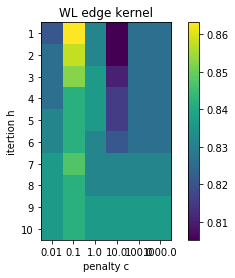

In [297]:
fig = plt.figure()
grid = np.asarray(perf).reshape(len(h_grid), len(c_grid))
plt.imshow(grid)
y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x = np.array([0, 1, 2, 3, 4, 5])
plt.xticks(x, c_grid)
plt.yticks(y, h_grid)
plt.xlabel('penalty c')
plt.ylabel('itertion h')
plt.title('WL edge kernel')
plt.colorbar()
plt.show()

fig.savefig('graph_edge.png')

## Optimal Parameters

In [305]:
#Compute optimal Kernel matrix 
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
h = 2
#compute Kernel matrix K, given H  
K = np.zeros([N, N])
for i in range(N): 
    for j in range(N):
        if (i <= j ):
            graph1 = X[i, ]
            graph2 = X[j, ]
            K[i, j] = wl_edge_kernel(graph1, graph2, h)
        else: 
            K[i, j] = K[j, i]
    

In [304]:
perf_all_val = []
c = 0.1
for t in range(100):  
    random_state = int(t)
    np.random.seed(random_state)
    idx_perm = np.random.permutation(N)

    #Permute the data 
    y_perm = y[idx_perm]
    K_perm = K[:, idx_perm]
    K_perm = K_perm[idx_perm, :]

    #The paper use 10-folder CV (training: 90%; test: 10%)
    num_train = int (N * (9/10))
    num_test = N - num_train 

    #Split the kernel matrix 
    K_train = K_perm[0:num_train, 0:num_train] 
    K_test = K_perm[num_train:N, 0:num_train]
    y_train = y_perm[0:num_train]
    y_test = y_perm[num_train:N]

    #Fit classifier on training data 
    clf = svm.SVC(kernel = 'precomputed', C = c)
    clf.fit(K_train, y_train)

    #predict on test  
    y_pred_test = clf.predict(K_test)

    #accuracy on test set  
    acc = accuracy_score(y_test, y_pred_test);
    perf_all_val.append(acc) 
    
print(max(perf))
print("mean: ", np.mean(perf_all_val), np.std(perf_all_val)) 
#mean:  0.873684210526 0.0622745240326

0.863157894737
mean:  0.873157894737 0.0670283356793
